# ![](https://www.gitbook.com/cdn-cgi/image/width=40,height=40,fit=contain,dpr=1.25,format=auto/https%3A%2F%2F2454584560-files.gitbook.io%2F~%2Ffiles%2Fv0%2Fb%2Fgitbook-28427.appspot.com%2Fo%2Fspaces%252F-LD4FEpEuXG2BKuShFdL%252Favatar.png%3Fgeneration%3D1526949040265200%26alt%3Dmedia) angr

Briefly, it is a multi-architecture binary analysis toolkit with Python API.
It allows you to perform:

- dynamic symbolic execution
- dependency analysis
- recovery of control-flow graph
- function identifier recovery
- exploitation / vulnerability discovery (including fuzzing)

## Simple binary

In [1]:
!echo 'abcd' | './binaries/simple'
!echo -e '\n------------'
!readelf -l 'binaries/simple'

Nice try!
------------

Elf file type is DYN (Shared object file)
Entry point 0x10c0
There are 13 program headers, starting at offset 64

Program Headers:
  Type           Offset             VirtAddr           PhysAddr
                 FileSiz            MemSiz              Flags  Align
  PHDR           0x0000000000000040 0x0000000000000040 0x0000000000000040
                 0x00000000000002d8 0x00000000000002d8  R      0x8
  INTERP         0x0000000000000318 0x0000000000000318 0x0000000000000318
                 0x000000000000001c 0x000000000000001c  R      0x1
      [Requesting program interpreter: /lib64/ld-linux-x86-64.so.2]
  LOAD           0x0000000000000000 0x0000000000000000 0x0000000000000000
                 0x00000000000006a8 0x00000000000006a8  R      0x1000
  LOAD           0x0000000000001000 0x0000000000001000 0x0000000000001000
                 0x00000000000002b5 0x00000000000002b5  R E    0x1000
  LOAD           0x0000000000002000 0x0000000000002000 0x0000000000002000


### Loading a binary file

In [2]:
import angr
import monkeyhex
import itertools
from IPython.display import display

base_addr = 0

project = angr.Project('binaries/simple', main_opts={'base_addr': base_addr})
project.loader

<Loaded simple, maps [0x0:0x607fff]>

In [3]:
print('Architecture & Entry')
display(project.arch)
display(project.entry)
display(project.filename)

print('All ELF objects')
display(project.loader.all_elf_objects)

print('Main object')
display(project.loader.main_object)

print('Shared objects')
display(project.loader.shared_objects)

print('Addresses')
display(project.loader.min_addr)
display(project.loader.max_addr)
display(project.loader.find_symbol('_start'))
display(project.loader.find_symbol('main'))
display(list(itertools.islice(project.loader.symbols, 15)))

Architecture & Entry


<Arch AMD64 (LE)>

0x10c0

'binaries/simple'

All ELF objects


[<ELF Object simple, maps [0x0:0x4017]>,
 <ELF Object libc-2.31.so, maps [0x100000:0x2f14d7]>,
 <ELF Object ld-2.31.so, maps [0x300000:0x32f18f]>]

Main object


<ELF Object simple, maps [0x0:0x4017]>

Shared objects


OrderedDict([('simple', <ELF Object simple, maps [0x0:0x4017]>),
             ('libc.so.6',
              <ELF Object libc-2.31.so, maps [0x100000:0x2f14d7]>),
             ('ld-linux-x86-64.so.2',
              <ELF Object ld-2.31.so, maps [0x300000:0x32f18f]>),
             ('extern-address space',
              <ExternObject Object cle##externs, maps [0x400000:0x47ffff]>),
             ('cle##tls',
              <ELFTLSObjectV2 Object cle##tls, maps [0x500000:0x51500f]>)])

Addresses


0x0

0x607fff

<Symbol "_start" in simple at 0x10c0>

<Symbol "main" in simple at 0x11a9>

[<Symbol "" in simple at 0x0>,
 <Symbol "_ITM_deregisterTMCloneTable" in simple (import)>,
 <Symbol "printf" in simple (import)>,
 <Symbol "__libc_start_main" in simple (import)>,
 <Symbol "strcmp" in simple (import)>,
 <Symbol "__gmon_start__" in simple (import)>,
 <Symbol "gets" in simple (import)>,
 <Symbol "exit" in simple (import)>,
 <Symbol "_ITM_registerTMCloneTable" in simple (import)>,
 <Symbol "__cxa_finalize" in simple (import)>,
 <Symbol "" in simple at 0x0>,
 <Symbol "" in simple at 0x0>,
 <Symbol "crtstuff.c" in simple at 0x0>,
 <Symbol "simple.c" in simple at 0x0>,
 <Symbol "crtstuff.c" in simple at 0x0>]

### Getting a disassembled block of code

`angr` can give us info about the disassembly. We get the instructions along with addresses (we can also retrieve opcodes for each used mnemonic).

In [4]:
from cle.backends.elf.symbol import ELFSymbol

main_symbol: ELFSymbol = project.loader.find_symbol('main')
block = project.factory.block(main_symbol.rebased_addr)
# Show the "pretty" disassembly
block.pp()
push_instruction = block.disassembly.insns[1]
print(push_instruction.mnemonic, push_instruction.opcode)
mov_instruction = block.disassembly.insns[4]
print(mov_instruction.mnemonic, mov_instruction.opcode)
print(mov_instruction.mnemonic, mov_instruction.opcode)


      main:
11a9  endbr64 
11ad  push    rbp
11ae  mov     rbp, rsp
11b1  sub     rsp, 0x20
11b5  mov     rax, qword ptr  fs:[0x28]
11be  mov     qword ptr [rbp-0x8], rax
11c2  xor     eax, eax
11c4  lea     rax, [rbp-0x20]
11c8  mov     rdi, rax
11cb  mov     eax, 0x0
11d0  call    gets
push [85, 0, 0, 0]
mov [139, 0, 0, 0]
mov [139, 0, 0, 0]


### Control-flow graph

As this binary is tiny, it makes little difference when we autoload external symbols.
In real world it can make big difference (unless, you have a lot of time) - remember to pass `load_options={'auto_load_libs': False}` to `Project` constructor.

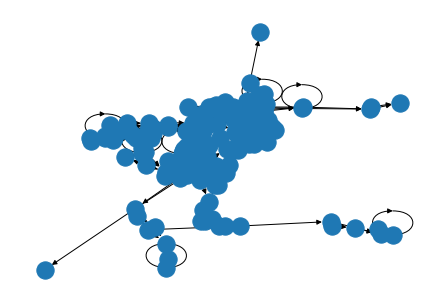

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

start_symbol = project.loader.find_symbol('_start')

cfg = project.analyses.CFGEmulated(starts=[start_symbol.rebased_addr])
program_graph = cfg.graph

nx.draw(program_graph)
plt.show()

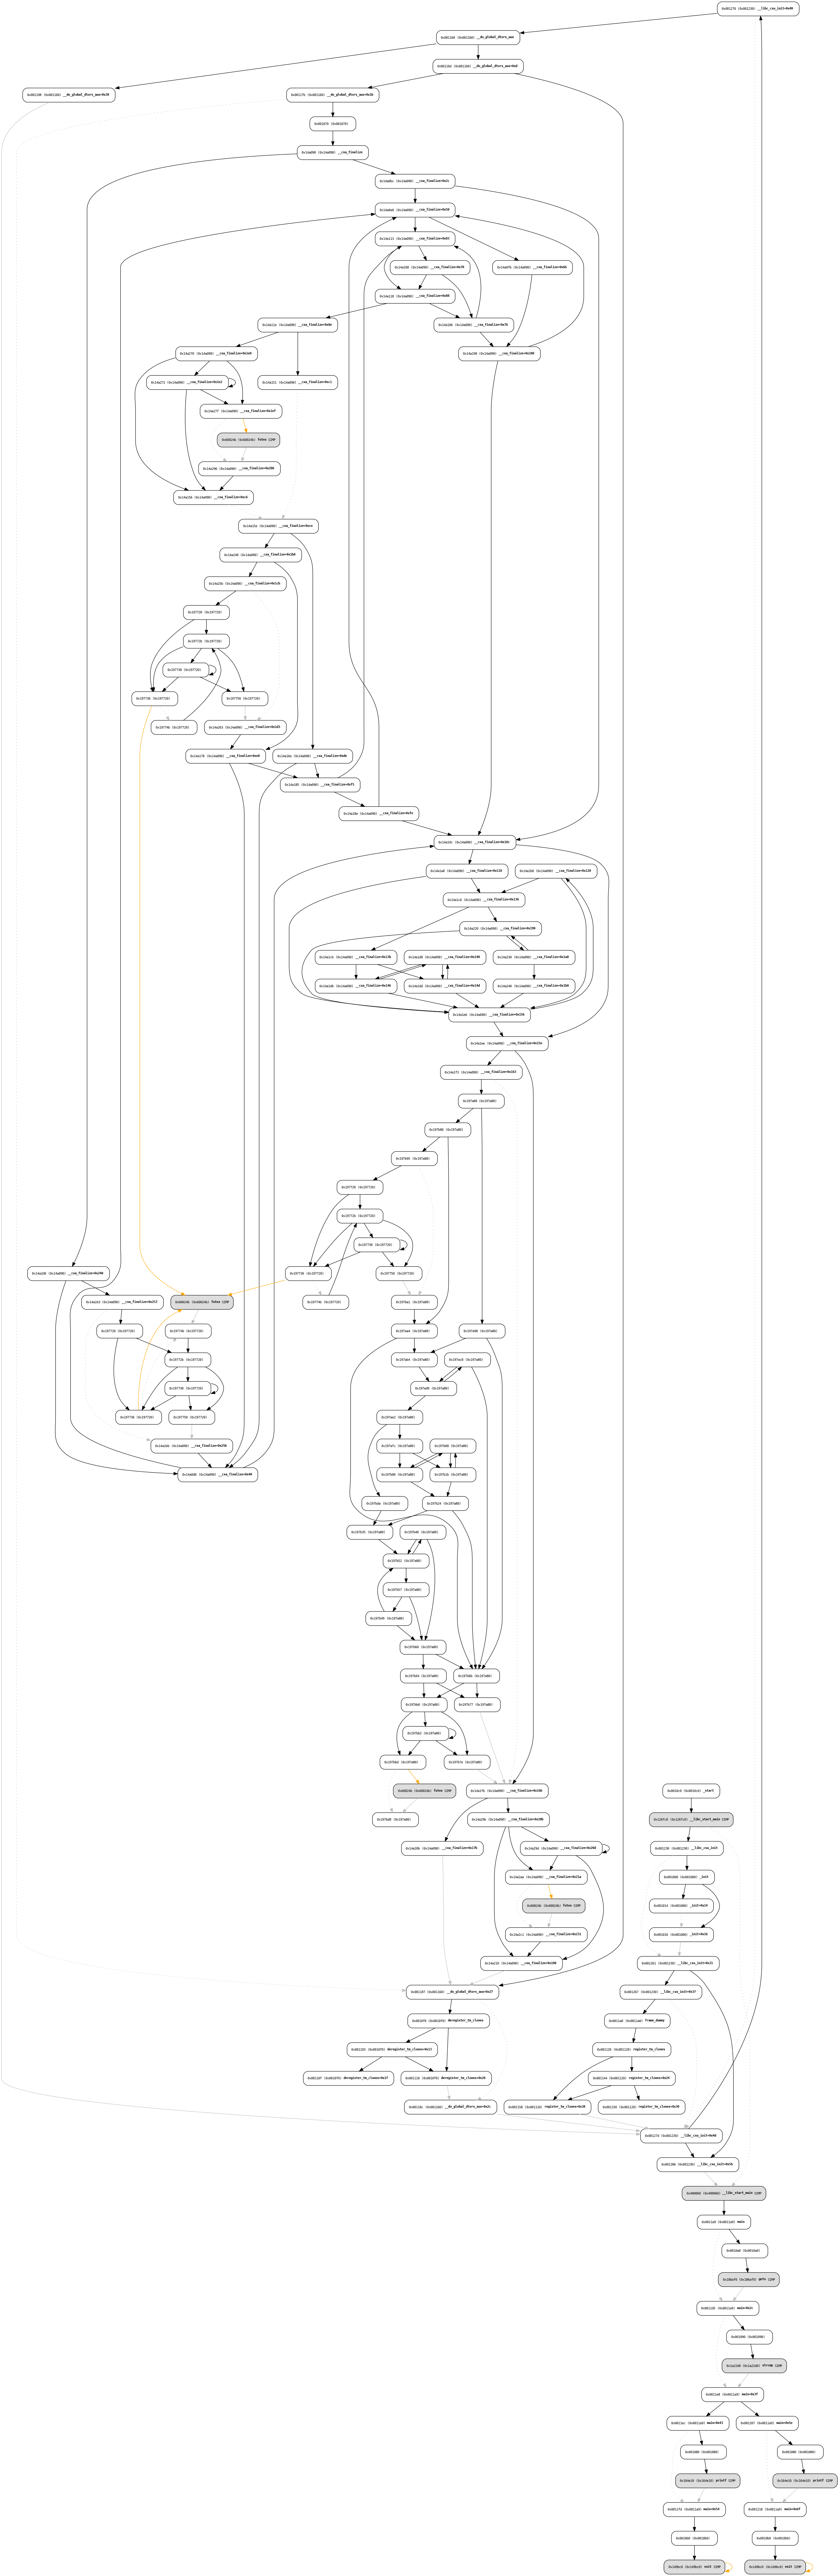

In [6]:
from IPython.core.display import Image
from angrutils import plot_cfg

plot_cfg(cfg, 'images/_start', asminst=True, remove_imports=True, remove_path_terminator=True)
display(Image('images/_start.png'))

Putting graph into NetworkX with defaults doesn't seem to be the best way.
As you can see, `angrutils` does the heavy-lifting and formats the graph appropriately.

Another thing to notice, the actual program is very small.
In this example, it is noticeable from the first glance.
Most of the code is from the `_start` function which is generated by the compiler (usually, it is even shipped along the compiler).
This function does setup several things, like runtime setup (loading libs etc.),
initializing stack, and after many other things, jumping into `main`.

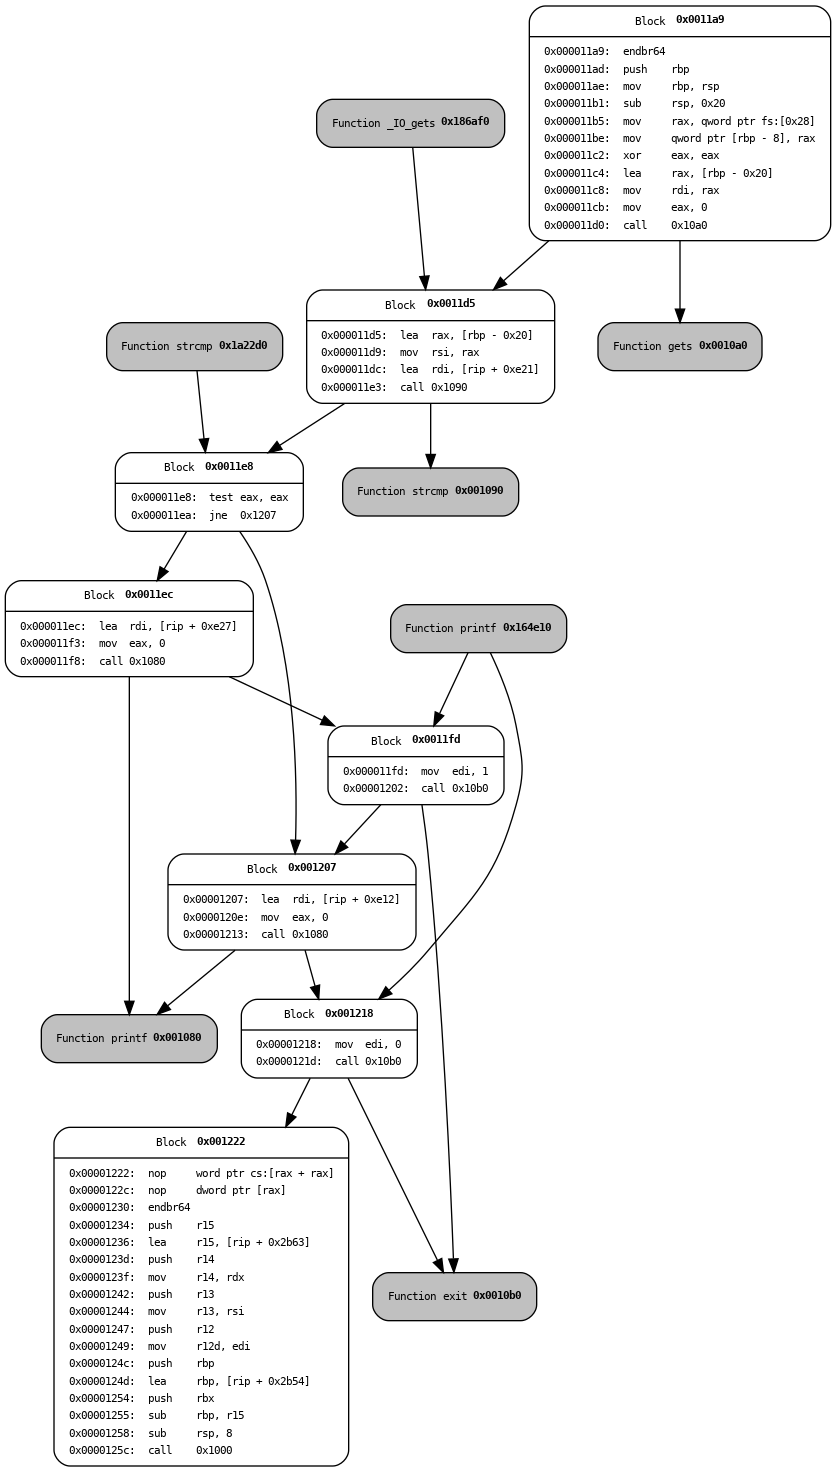

In [7]:
from angrutils import plot_func_graph

main_function = project.kb.functions.get('main')
plot_func_graph(project, main_function.transition_graph, f'images/{main_function.name}', asminst=True, vexinst=False)
display(Image(f'images/{main_function.name}.png'))

### Symbolic execution

In [8]:
import claripy as cp

sym_input = [cp.BVS('user_input', 8 * 64)]
flag = cp.Concat(*sym_input + [cp.BVV(b'\n')])

state = project.factory.full_init_state(
    args=['./simple'],
    add_options=angr.options.unicorn,
    stdin=flag
)

sim_manager = project.factory.simulation_manager(state)
sim_manager.run()

result = []
for x in sim_manager.deadended:
    if not b'Nice try!' in x.posix.dumps(1):
        result.append(x)

result[0].posix.dumps(0)

WARNING | 2022-01-26 15:47:36,202 | angr.simos.simos | stdin is constrained to 65 bytes (has_end=True). If you are only providing the first 65 bytes instead of the entire stdin, please use stdin=SimFileStream(name='stdin', content=your_first_n_bytes, has_end=False).
WARNING | 2022-01-26 15:47:36,548 | angr.storage.memory_mixins.default_filler_mixin | The program is accessing memory or registers with an unspecified value. This could indicate unwanted behavior.
WARNING | 2022-01-26 15:47:36,550 | angr.storage.memory_mixins.default_filler_mixin | angr will cope with this by generating an unconstrained symbolic variable and continuing. You can resolve this by:
WARNING | 2022-01-26 15:47:36,550 | angr.storage.memory_mixins.default_filler_mixin | 1) setting a value to the initial state
WARNING | 2022-01-26 15:47:36,551 | angr.storage.memory_mixins.default_filler_mixin | 2) adding the state option ZERO_FILL_UNCONSTRAINED_{MEMORY,REGISTERS}, to make unknown regions hold null
WARNING | 2022-01-

b'effective_python_angr\x00\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf1\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\n'

#### ...more optimal approach if we now the size and ranges

Here we're going to use [Unicorn](https://www.unicorn-engine.org/docs/) - the Python-based CPU emulator,
for symbolic execution.

We're also going to optimize the process by giving it constraints - sometimes we
can easily get the input size from the disassembly - along with knowledge how can we differentiate failure from success.
Given these bits of information, we can construct a better model for the program.
This can be crucial, because it can take some time to get the answer.

In [9]:
sym_input = [cp.BVS(f'user_input_{i}', 8) for i in range(21)]
flag = cp.Concat(*sym_input + [cp.BVV(b'\x00')])

state = project.factory.full_init_state(
    args=['./simple'],
    add_options=angr.options.unicorn,
    stdin=flag
)

sim_manager = project.factory.simulation_manager(state)
sim_manager.run()

for char in sym_input:
    state.solver.add(char < ord('{'))
    state.solver.add(char > ord('@'))

result = []
for x in sim_manager.deadended:
    if not b'Nice try!' in x.posix.dumps(1):
        result.append(x)

valid_input = result[0].posix.dumps(0)
''.join([chr(x) for x in valid_input[:-1]])

WARNING | 2022-01-26 15:47:41,302 | angr.simos.simos | stdin is constrained to 22 bytes (has_end=True). If you are only providing the first 22 bytes instead of the entire stdin, please use stdin=SimFileStream(name='stdin', content=your_first_n_bytes, has_end=False).
WARNING | 2022-01-26 15:47:41,616 | angr.storage.memory_mixins.default_filler_mixin | Filling memory at 0x7fffffffffeff8c with 4 unconstrained bytes referenced from 0x10c9 (_start+0x9 in simple (0x10c9))


'effective_python_angr'

#### More on Claripy solvers

Claripy library is used for symbolic execution. We can do various things with it:

In [10]:
import numpy as np

solver = cp.Solver()
x = cp.BVS('x', 16)
y = cp.BVS('y', 16)

solver.add(4 * x == 10 * y)
solver.add(y == 10)
solver.add(x > 25)

# We have to bind the numbers to 16 bit unsigned integers
# As the solutions from Claripy (with these constraint) overflow
x_solutions = np.array(
    sorted([num for num in solver.eval(x, 100)]),
    dtype='uint16'
)

print(x_solutions)
assert np.all(x_solutions * 4 == 100)

[16409 32793 49177]
